In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
from functools import partial

import bayesflow as bf
import numpy as np
import pandas as pd
import tensorflow as tf
from src.config import cfg
from src.ddm import (
    configurator,
    get_batch_simulator,
    get_prior,
    random_num_obs,
)
from src.models import get_amortizer
from src.plot_utils import color_dict, plot_sbc_ecdf, plot_true_vs_ci
from src.posterior_sbc import posterior_sbc

/Users/marvin/miniforge3/envs/gin/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size": 16})
plt.rcParams["text.latex.preamble"] = "".join([r"\usepackage{amsmath}"])

In [4]:
# set seeds of numpy and tensorflow
np.random.seed(42)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
tf.random.set_seed(42)

In [5]:
def preprocess_data(df):
    df["response_corr"] = df["response_corr"].replace(0, -1)
    df = np.array([df["response_time"] * df["response_corr"], df["n200lat"]]).T
    df = df[df[:, 1] > -10]

    df = df[: cfg.num_test_observations]

    return df


subject_indices = [1, 6]

real_data = {
    subject_idx: preprocess_data(
        pd.read_csv(
            f"data/sub-{subject_idx:03}_task-pdm_acq-outsideMRT_runs_beh_n200lat.csv"
        )
    )
    for subject_idx in subject_indices
}

print([real_observations.shape for real_observations in real_data.values()])

[(60, 2), (60, 2)]


In [6]:
os.makedirs("data/", exist_ok=True)

In [7]:
models = {
    "m2": {},
    "m6": {},
}

for model_name in models.keys():
    model_code = f"affine_lowN_{model_name}"
    models[model_name]["model_code"] = model_code
    models[model_name]["checkpoint_path"] = f"checkpoints/{model_code}"
    models[model_name]["data_path"] = f"data/{model_code}_test_data.pkl"
    models[model_name]["posterior_path"] = f"data/{model_code}_posterior_samples.pkl"

    models[model_name]["param_names"] = cfg.param_names[model_name]
    models[model_name]["num_params"] = len(models[model_name]["param_names"])

    context_gen = bf.simulation.ContextGenerator(
        non_batchable_context_fun=partial(
            random_num_obs, num_obs_min=cfg.num_obs_min, num_obs_max=cfg.num_obs_max
        )
    )

    prior = bf.simulation.Prior(batch_prior_fun=get_prior(model_name))
    simulator = bf.simulation.Simulator(
        batch_simulator_fun=get_batch_simulator(model_name),
        context_generator=context_gen,
    )
    generative_model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

    amortizer = get_amortizer(cfg, models[model_name]["num_params"])

    trainer = bf.trainers.Trainer(
        amortizer=amortizer,
        generative_model=generative_model,
        configurator=configurator,
        checkpoint_path=models[model_name]["checkpoint_path"],
        max_to_keep=1,
    )

    models[model_name]["trainer"] = trainer

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 141, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: ()
INFO:root:No optional simulation batchable context provided.
INFO:root:Loaded loss history from checkpoints/affine_lowN_m2/history_300.pkl.
INFO:root:Networks loaded from checkpoints/affine_lowN_m2/ckpt-300
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 53, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No 

## Simulate closed-world test data for each model


In [8]:
for model in models.keys():
    trainer = models[model]["trainer"]

    # if test_data already exists, skip
    if os.path.exists(models[model]["data_path"]):
        print(f"Loading test data for model {model} from {models[model]['data_path']}")
        test_data = pickle.load(open(models[model]["data_path"], "rb"))

    else:
        print(f"Generating test data for model {model}")
        theta_true = get_prior(model)(cfg.num_test_datasets)
        y_true_N = get_batch_simulator(model)(theta_true, cfg.num_test_observations)
        y_true_N_rep = get_batch_simulator(model)(theta_true, cfg.num_test_observations)
        y_true_2N = np.concatenate([y_true_N, y_true_N_rep], axis=1)

        test_data_N = trainer.configurator(
            {
                "prior_draws": theta_true,
                "sim_data": y_true_N,
                "sim_non_batchable_context": cfg.num_test_observations,
            }
        )

        test_data_2N = trainer.configurator(
            {
                "prior_draws": theta_true,
                "sim_data": y_true_2N,
                "sim_non_batchable_context": 2 * cfg.num_test_observations,
            }
        )

        # save test data with pickle
        test_data = {"test_data_N": test_data_N, "test_data_2N": test_data_2N}
        with open(models[model]["data_path"], "wb") as f:
            pickle.dump(test_data, f)

    # save test data in models dictionary
    models[model]["test_data_N"] = test_data["test_data_N"]
    models[model]["test_data_2N"] = test_data["test_data_2N"]

Loading test data for model m2 from data/affine_lowN_m2_test_data.pkl
Loading test data for model m6 from data/affine_lowN_m6_test_data.pkl


In [9]:
for model in models.keys():
    test_data_N = models[model]["test_data_N"]
    test_data_2N = models[model]["test_data_2N"]
    print(f"Model: {model}")
    print(f"Test data N: observations {test_data_N['summary_conditions'].shape}")
    print(f"Test data N: params {test_data_N['parameters'].shape}")
    print(
        f"Test data N: conditions {test_data_N['direct_conditions'][0]}, log(cfg.num_test_observations)={np.log(cfg.num_test_observations)}"
    )
    print("")
    print(f"Test data 2N: observations {test_data_2N['summary_conditions'].shape}")
    print(f"Test data 2N: params {test_data_2N['parameters'].shape}")
    print(
        f"Test data 2N: conditions {test_data_2N['direct_conditions'][0]}, log(2*cfg.num_test_observations)={np.log(2*cfg.num_test_observations)}"
    )

    print("\n----------------------\n")

Model: m2
Test data N: observations (200, 60, 3)
Test data N: params (200, 8)
Test data N: conditions [4.0943446], log(cfg.num_test_observations)=4.0943445622221

Test data 2N: observations (200, 120, 3)
Test data 2N: params (200, 8)
Test data 2N: conditions [4.787492], log(2*cfg.num_test_observations)=4.787491742782046

----------------------

Model: m6
Test data N: observations (200, 60, 3)
Test data N: params (200, 8)
Test data N: conditions [4.0943446], log(cfg.num_test_observations)=4.0943445622221

Test data 2N: observations (200, 120, 3)
Test data 2N: params (200, 8)
Test data 2N: conditions [4.787492], log(2*cfg.num_test_observations)=4.787491742782046

----------------------



## Sampling from the amortized posteriors


In [10]:
for model in models.keys():
    if os.path.exists(models[model]["posterior_path"]):
        print(f"Found posterior samples for model {model}, loading them.")
        posterior_samples = pickle.load(open(models[model]["posterior_path"], "rb"))
        models[model]["posterior_samples_N"] = posterior_samples["posterior_samples_N"]
        models[model]["posterior_samples_2N"] = posterior_samples[
            "posterior_samples_2N"
        ]

    else:
        print(f"Posterior samples not found for model {model}, sampling them.")
        trainer = models[model]["trainer"]
        test_data_N = models[model]["test_data_N"]
        test_data_2N = models[model]["test_data_2N"]

        posterior_samples_N = trainer.amortizer.sample(
            test_data_N, n_samples=cfg.num_posterior_samples
        )

        posterior_samples_2N = trainer.amortizer.sample(
            test_data_2N, n_samples=cfg.num_posterior_samples
        )

        with open(models[model]["posterior_path"], "wb") as f:
            pickle.dump(
                {
                    "posterior_samples_N": posterior_samples_N,
                    "posterior_samples_2N": posterior_samples_2N,
                },
                f,
            )

        models[model]["posterior_samples_N"] = posterior_samples_N
        models[model]["posterior_samples_2N"] = posterior_samples_2N

Found posterior samples for model m2, loading them.
Found posterior samples for model m6, loading them.


In [11]:
for model in models.keys():
    for subject_idx, y_obs in real_data.items():
        path = f"data/{models[model]['model_code']}_posterior_dataset_{subject_idx}.pkl"
        if os.path.exists(path):
            print(
                f"Found posterior samples for data set {subject_idx} / model {model}, loading them."
            )
            posterior_real = pickle.load(open(path, "rb"))
            models[model][f"posterior_samples_y_dataset_{subject_idx}"] = (
                posterior_real["posterior_samples_y"]
            )
            models[model][f"conditional_posterior_samples_dataset_{subject_idx}"] = (
                posterior_real["conditional_posterior_samples"]
            )

        else:
            print(
                f"Posterior samples not found for data set {subject_idx} / model {model}, sampling them."
            )
            trainer = models[model]["trainer"]
            posterior_samples_y, conditional_posterior_samples = posterior_sbc(
                y_obs=y_obs,
                trainer=trainer,
                ppred_simulator=get_batch_simulator(model),
                num_ppred_samples=200,
                num_posterior_samples=cfg.num_posterior_samples,
            )

            with open(path, "wb") as f:
                pickle.dump(
                    {
                        "posterior_samples_y": posterior_samples_y,
                        "conditional_posterior_samples": conditional_posterior_samples,
                    },
                    f,
                )

            models[model][f"posterior_samples_y_dataset_{subject_idx}"] = (
                posterior_samples_y
            )
            models[model][f"conditional_posterior_samples_dataset_{subject_idx}"] = (
                conditional_posterior_samples
            )

Found posterior samples for data set 1 / model m2, loading them.
Found posterior samples for data set 6 / model m2, loading them.
Found posterior samples for data set 1 / model m6, loading them.
Found posterior samples for data set 6 / model m6, loading them.


## Plotting


In [12]:
def plot_closed_world_eval(
    theta_true,
    posterior_samples_N,
    posterior_samples_2N,
    shortcode,
    param_names,
    colors,
):
    # recovery N
    f = plot_true_vs_ci(
        theta_true,
        posterior_samples_N,
        param_names,
        point_colors=colors,
        line_color="#CCCCCC",
    )
    f.savefig(f"plots/{shortcode}_N_recovery.pdf", dpi=300)

    # recovery 2N
    f = plot_true_vs_ci(
        theta_true,
        posterior_samples_2N,
        param_names,
        point_colors=colors,
        line_color="#CCCCCC",
    )
    f.savefig(f"plots/{shortcode}_2N_recovery.pdf", dpi=300)

    # prior sbc N
    f = plot_sbc_ecdf(
        posterior_samples_N,
        theta_true,
        rank_ecdf_colors=colors,
        param_names=param_names,
        difference=True,
        stacked=True,
        num_legend_cols=1,
        legend_position="center right",
        legend_bbox_to_anchor=(1.4, 0.5),
        fig_size=(5, 5),
        legend_fontsize="x-large",
        label_fontsize="xx-large",
        plot_legend=False,
    )
    f.savefig(f"plots/{shortcode}_N_prior_sbc.pdf", dpi=300)

    # prior sbc 2N
    f = plot_sbc_ecdf(
        posterior_samples_2N,
        theta_true,
        rank_ecdf_colors=colors,
        param_names=param_names,
        difference=True,
        stacked=True,
        num_legend_cols=1,
        legend_position="center right",
        legend_bbox_to_anchor=(1.4, 0.5),
        fig_size=(5, 5),
        legend_fontsize="x-large",
        label_fontsize="xx-large",
        plot_legend=False,
    )
    f.savefig(f"plots/{shortcode}_2N_prior_sbc.pdf", dpi=300)

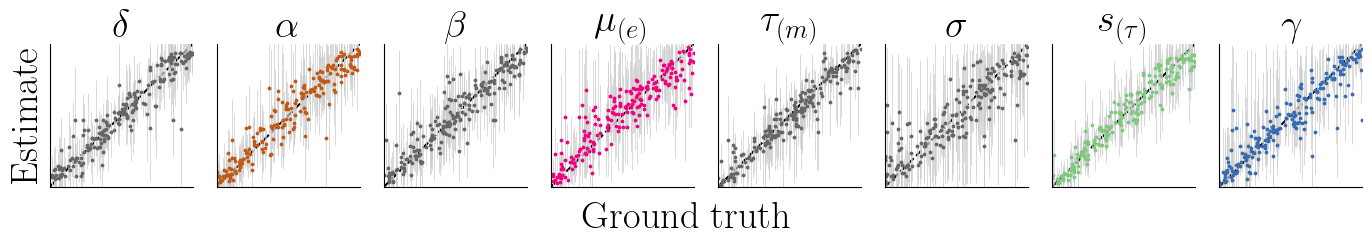

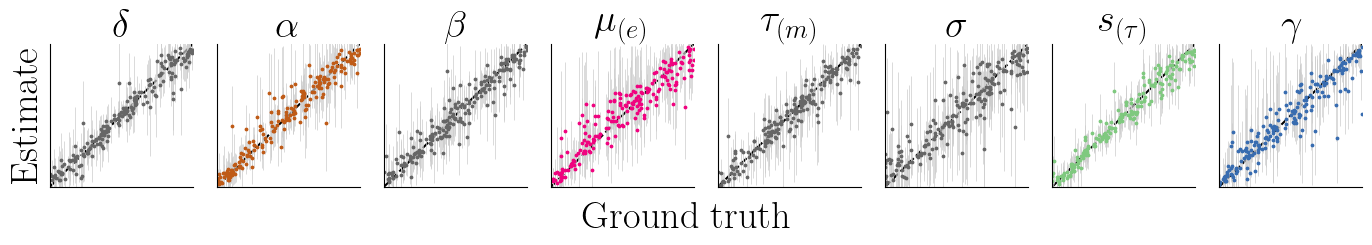

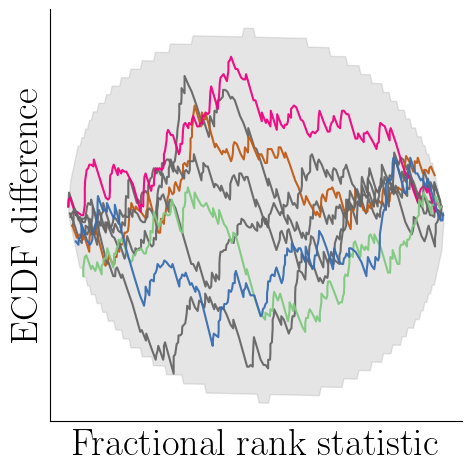

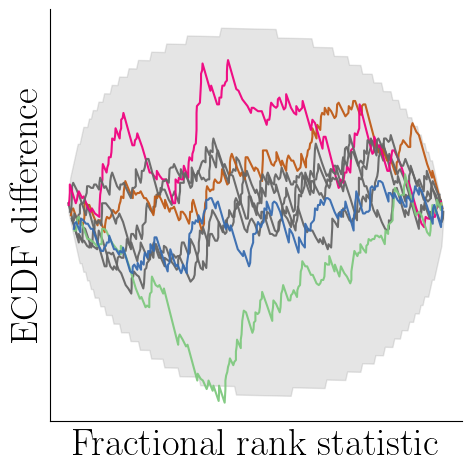

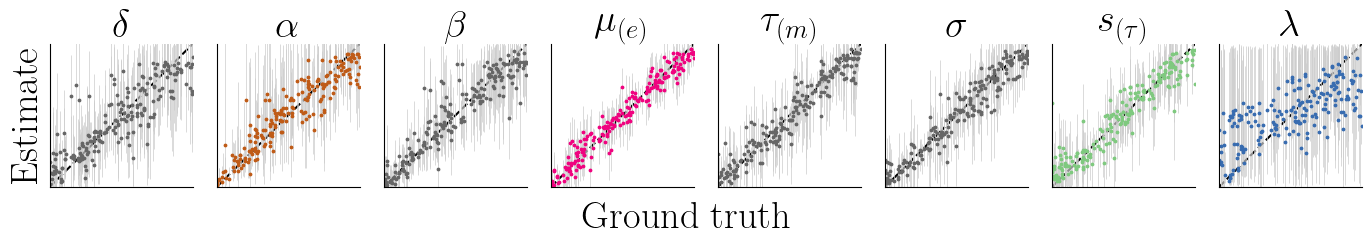

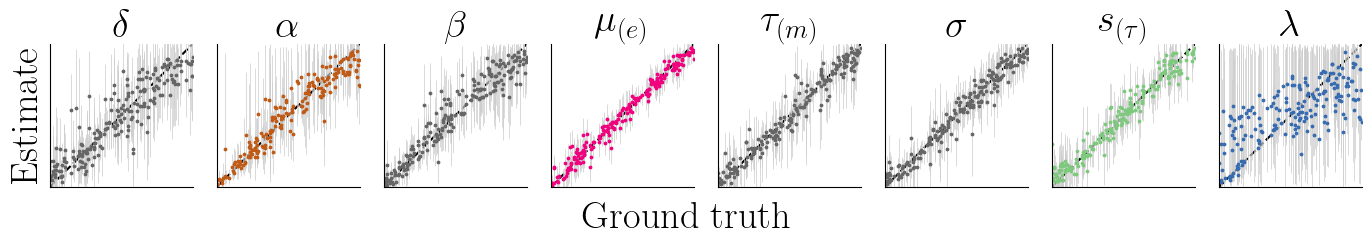

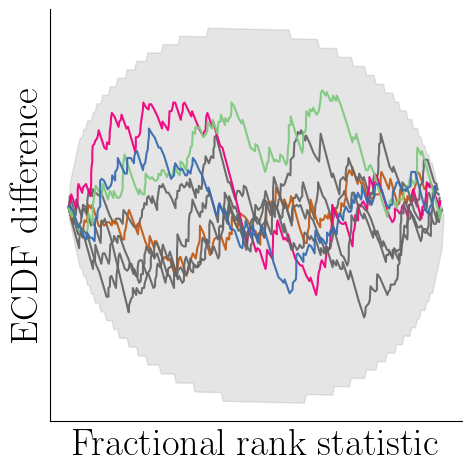

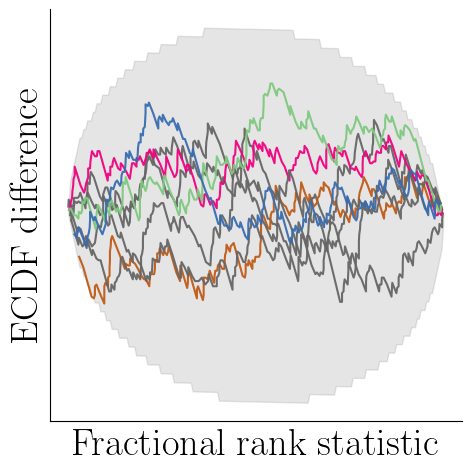

In [13]:
for model in models.keys():
    param_names = models[model]["param_names"]

    colors = [color_dict[param] for param in param_names]

    theta_true = models[model]["test_data_N"]["parameters"]
    assert np.all(
        theta_true == models[model]["test_data_2N"]["parameters"]
    ), "Parameters are not the same for N and 2N"

    posterior_samples_N = models[model]["posterior_samples_N"]
    posterior_samples_2N = models[model]["posterior_samples_2N"]

    # plot N
    plot_closed_world_eval(
        theta_true=theta_true,
        posterior_samples_N=posterior_samples_N,
        posterior_samples_2N=posterior_samples_2N,
        shortcode=f"{model}",
        param_names=param_names,
        colors=colors,
    )

In [16]:
def plot_real_data_eval(
    dataset_identifiers: list,
    posterior_samples_y: list,
    conditional_posterior_samples: list,
    shortcode,
    param_names,
    colors,
):
    for id, post, cond_post in zip(
        dataset_identifiers, posterior_samples_y, conditional_posterior_samples
    ):
        # recovery
        f = plot_true_vs_ci(
            post,
            cond_post,
            param_names,
            point_colors=colors,
            line_color="#CCCCCC",
        )
        f.savefig(f"plots/{shortcode}_dataset_{id}_conditional_recovery.pdf", dpi=300)

        # posterior sbc
        f = plot_sbc_ecdf(
            cond_post,
            post,
            rank_ecdf_colors=colors,
            param_names=param_names,
            difference=True,
            stacked=True,
            num_legend_cols=1,
            legend_position="center right",
            legend_bbox_to_anchor=(1.4, 0.5),
            fig_size=(5, 5),
            legend_fontsize="x-large",
            label_fontsize="xx-large",
            plot_legend=False,
        )

        f.savefig(f"plots/{shortcode}_dataset_{id}_posterior_sbc.pdf", dpi=300)

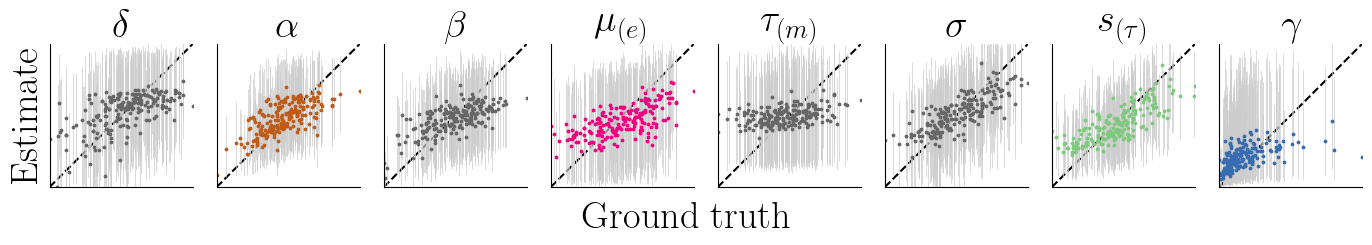

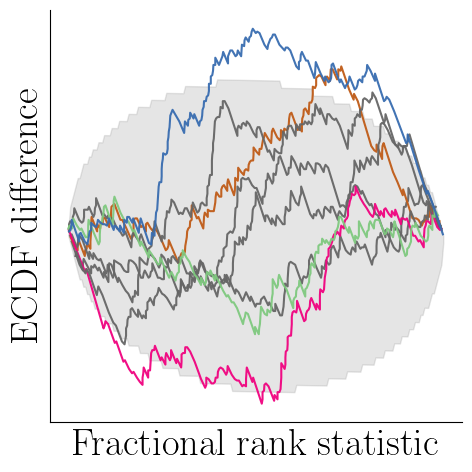

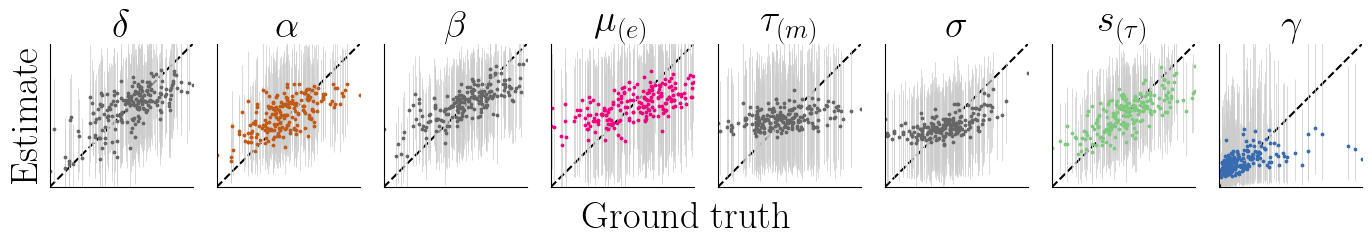

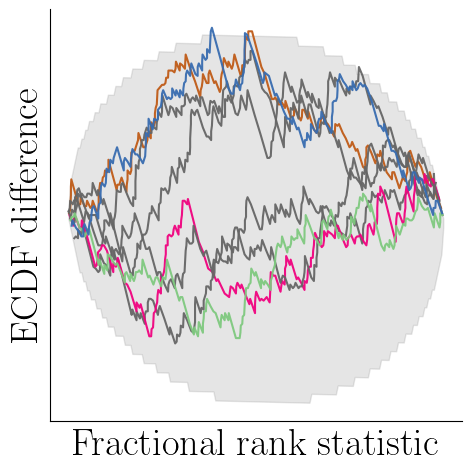

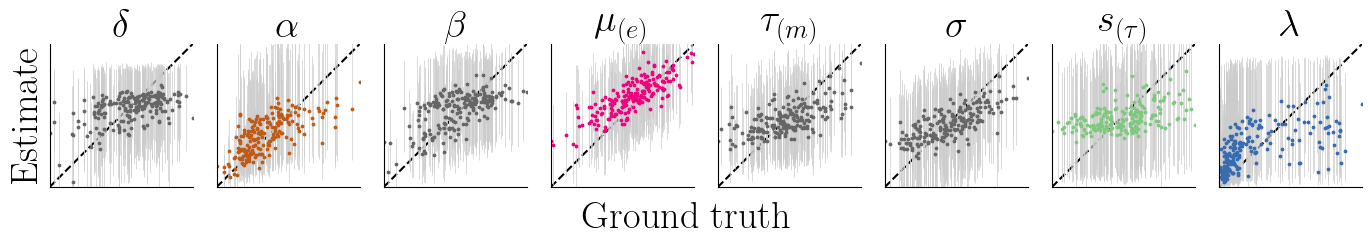

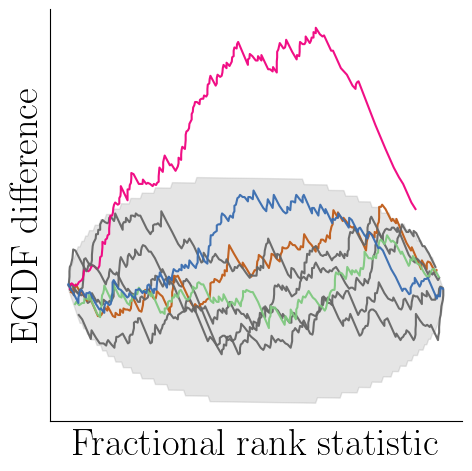

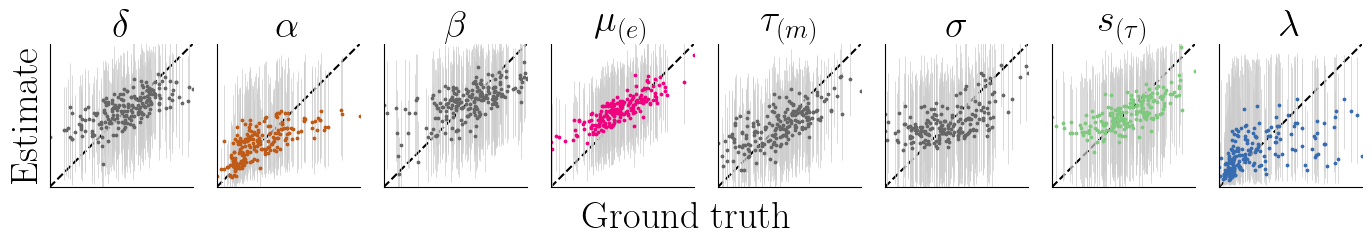

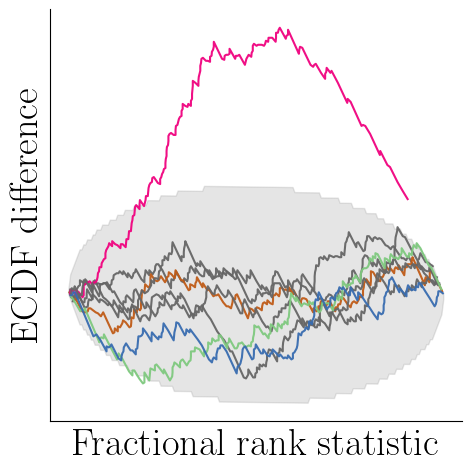

In [17]:
for model in models.keys():
    param_names = models[model]["param_names"]
    colors = [color_dict[param] for param in param_names]

    dataset_identifiers = real_data.keys()
    posterior_samples_y = [
        models[model][f"posterior_samples_y_dataset_{subject_idx}"]
        for subject_idx in dataset_identifiers
    ]
    conditional_posterior_samples = [
        models[model][f"conditional_posterior_samples_dataset_{subject_idx}"]
        for subject_idx in dataset_identifiers
    ]

    plot_real_data_eval(
        dataset_identifiers=dataset_identifiers,
        posterior_samples_y=posterior_samples_y,
        conditional_posterior_samples=conditional_posterior_samples,
        shortcode=f"{model}",
        param_names=param_names,
        colors=colors,
    )